<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer

from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# Warning
import warnings
warnings.filterwarnings("ignore")

### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [2]:
dataset = pd.read_csv("./Output/Arabidopsis_thaliana_GHLH_and_CYP_gene.csv")
dataset.head()

,id,sequence,length,class
0,AT1G51140.1,AAGTTTCTCTCACGTTCTCTTTTTTAATTTTAATTTCTCGCCGGAA...,2297,0
1,AT1G73830.1,ACTTTCTATTTTCACCAATTTTCAAAAAAAAAATAAAAATTGAAAC...,1473,0
2,AT1G09530.1,AGTTACAGACGATTTGGTCCCCTCTCTTCTCTCTCTGCGTCCGTCT...,2958,0
3,AT1G49770.1,ATGACTAATGCTCAAGAGTTGGGGCAAGAGGGTTTTATGTGGGGCA...,2205,0
4,AT1G68810.1,AAACTTTTGTCTCTTTTTAACTCTCTTAACTTTCGTTTCTTCTCCT...,1998,0


### 3 - Preprocessing and Model Utils
Instead of taking each base as an individual feature, we transform DNA sequences using the k-mer representation, a widely adopted method in DNA sequence analysis. The k-mer approach captures richer contextual information for each nucleotide by concatenating it with its subsequent bases to form k-mers. For example, the DNA sequence ‘ATGCCA’ can be tranformed into four 3-mers: "ATG, TGC, GCC, CCA", or into three 4-mers: "ATGC, TGCC, GCCA". In our experiments, we will try these k-mer length: **3, 4, 5, and 6**.

In [3]:
def kmer_count(sequence, k=3, step=1):
    """
    Utils: to count kmer occurence in DNA sequence and compute frequence
    """
    kmers_count = {}
    s = 0
    for i in range(0, len(sequence) - k + 1, step):
        kmer = sequence[i:i + k]
        s += 1
        if kmer in kmers_count:
            kmers_count[kmer] += 1
        else:
            kmers_count[kmer] = 1
    for key, value in kmers_count.items():
        kmers_count[key] = value / s

    return kmers_count

* Utils

In [4]:
def model_checkpoint(model_name):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/DeepFeedFw/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )
def plot_curve(history, list_of_metrics):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], '.-', label=m, lw=2, )
    plt.legend()

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [5]:
k = 3
sequences   = dataset['sequence']
kmers_count = []
for i in range(len(sequences)):
    kmers_count.append(kmer_count(sequences[i], k=k, step=1))

In [6]:
# Let build X vector, let say X_3 as k=3

v = DictVectorizer(sparse=False)
feature_values = v.fit_transform(kmers_count)
feature_names = v.get_feature_names_out()
X_3 = pd.DataFrame(feature_values, columns=feature_names)
X_3.head()

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,0.028758,0.018736,0.028322,0.024401,0.013508,0.008715,0.005664,0.018301,0.029630,0.012636,...,0.010022,0.025272,0.026144,0.013072,0.014815,0.016993,0.018301,0.024837,0.026144,0.043573
1,0.042148,0.015636,0.020394,0.040789,0.014956,0.004759,0.005438,0.015636,0.031271,0.007478,...,0.010197,0.035350,0.019714,0.008158,0.010877,0.010197,0.031271,0.036030,0.012916,0.062542
2,0.030108,0.019959,0.025034,0.021313,0.013532,0.008119,0.007442,0.016915,0.024357,0.011502,...,0.010487,0.032476,0.019959,0.015223,0.017591,0.022327,0.016238,0.029770,0.026725,0.046008
3,0.037222,0.016795,0.019065,0.029051,0.018157,0.009532,0.005447,0.011802,0.022696,0.006809,...,0.005901,0.024966,0.019065,0.012710,0.011348,0.020881,0.031321,0.027236,0.019519,0.059464
4,0.034068,0.019539,0.033567,0.018537,0.022044,0.011523,0.009519,0.012024,0.036072,0.014028,...,0.009018,0.028056,0.017535,0.006012,0.013026,0.019539,0.018537,0.019539,0.020541,0.049098


In [7]:
# Here we have target  column

y = dataset['class']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64

In [8]:
# We Split data to have evaluation testset never seen by our model. Also we make stratify split 
# to have equal class proportion in test set

X_train, X_test, y_train, y_test = train_test_split(X_3, y, train_size=0.8, stratify=y)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = 4**k

X_train: (304, 64)
X_test: (76, 64)
y_train: (304,)
y_test: (76,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [16]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=20)
save_callback = model_checkpoint(name)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
scores = model.evaluate(X_test, y_test, verbose=0)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,057 (426.00 KB)

 Trainable params: 109,057 (426.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4834 - loss: 0.6931 - val_accuracy: 0.5082 - val_loss: 0.6929
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5958 - loss: 0.6912 - val_accuracy: 0.5082 - val_loss: 0.6929
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5604 - loss: 0.6899 - val_accuracy: 0.5082 - val_loss: 0.6931
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6088 - loss: 0.6834 - val_accuracy: 0.5082 - val_loss: 0.6943
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5630 - loss: 0.6868 - val_accuracy: 0.5082 - val_loss: 0.6958
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5963 - loss: 0.6784 - val_accuracy: 0.5082 - val_loss: 0.6987
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5776 - loss: 0.6802 - val_accuracy: 0.5082 - val_loss: 0.7023
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6239 - loss: 0.6653 - val_accuracy: 0.5082 - val_loss: 0.

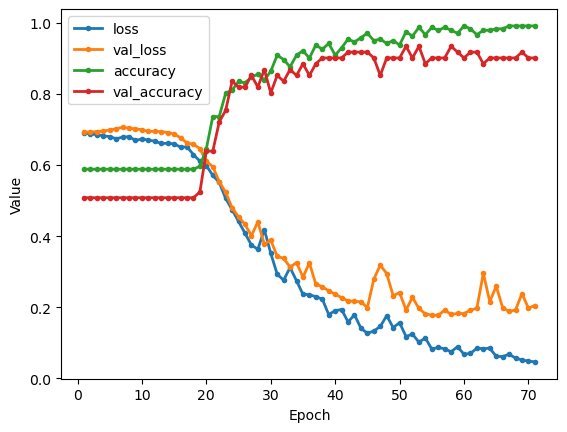

In [17]:
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [18]:
k = 4
sequences   = dataset['sequence']
kmers_count = []
for i in range(len(sequences)):
    kmers_count.append(kmer_count(sequences[i], k=k, step=1))

In [19]:
v = DictVectorizer(sparse=False)
feature_values = v.fit_transform(kmers_count)
feature_names = v.get_feature_names_out()
X_4 = pd.DataFrame(feature_values, columns=feature_names)
X_4.head()

,AAAA,AAAC,AAAG,AAAT,AACA,AACC,AACG,AACT,AAGA,AAGC,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
0,0.008282,0.008718,0.006975,0.004795,0.006103,0.003487,0.001744,0.007411,0.011334,0.005667,...,0.003923,0.009590,0.007411,0.004795,0.006103,0.007847,0.006975,0.008718,0.010026,0.017873
1,0.019728,0.004762,0.002721,0.014966,0.004082,0.002041,0.002041,0.007483,0.010884,0.002041,...,0.003401,0.017007,0.005442,0.002721,0.002041,0.002721,0.010884,0.019048,0.006803,0.025850
2,0.007783,0.007783,0.010152,0.004399,0.007107,0.003723,0.002707,0.006430,0.010829,0.005076,...,0.004061,0.013875,0.008122,0.004399,0.005076,0.009137,0.007107,0.010491,0.011168,0.017259
3,0.015441,0.005450,0.006812,0.009537,0.006358,0.003633,0.001362,0.005450,0.009083,0.003179,...,0.002271,0.014078,0.004087,0.004541,0.004087,0.006812,0.013170,0.012262,0.009083,0.024977
4,0.011529,0.006015,0.010025,0.006516,0.009023,0.002506,0.003509,0.004511,0.016040,0.007519,...,0.002005,0.011028,0.004511,0.002005,0.006015,0.008020,0.007018,0.008521,0.011028,0.022556


In [20]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_4, y, train_size=0.8, stratify=y)

NUM_CLASS  = 1
SEQ_LENGTH = 4**k

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [27]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=20)
save_callback = model_checkpoint(name)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
scores = model.evaluate(X_test, y_test, verbose=0)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,009 (418.00 KB)

 Trainable params: 107,009 (418.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5701 - loss: 0.6918 - val_accuracy: 0.6066 - val_loss: 0.6848
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5599 - loss: 0.6872 - val_accuracy: 0.6066 - val_loss: 0.6790
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5573 - loss: 0.6843 - val_accuracy: 0.6066 - val_loss: 0.6727
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5417 - loss: 0.6887 - val_accuracy: 0.6066 - val_loss: 0.6697
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5667 - loss: 0.6757 - val_accuracy: 0.6066 - val_loss: 0.6654
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5385 - loss: 0.6830 - val_accuracy: 0.6066 - val_loss: 0.6624
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5875 - loss: 0.6675 - val_accuracy: 0.6066 - val_loss: 0.6580
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5484 - loss: 0.6720 - val_accuracy: 0.6066 - val_loss: 0.6555

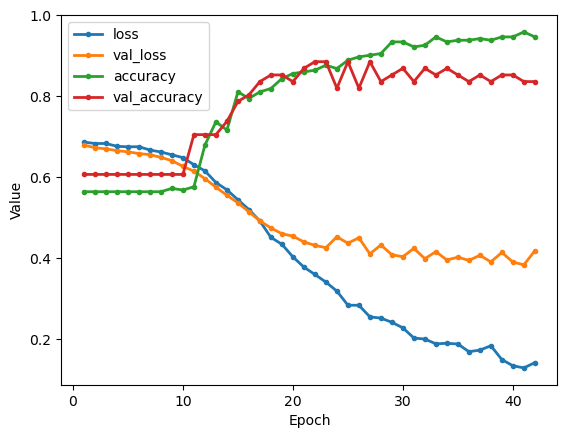

In [28]:
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [29]:
k = 5
sequences   = dataset['sequence']
kmers_count = []
for i in range(len(sequences)):
    kmers_count.append(kmer_count(sequences[i], k=k, step=1))

In [30]:
v = DictVectorizer(sparse=False)
feature_values = v.fit_transform(kmers_count)
feature_names = v.get_feature_names_out()
X_5 = pd.DataFrame(feature_values, columns=feature_names)
X_5.head()

,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003053,0.000872,0.003053,0.001308,0.002617,0.002181,0.000436,0.003489,0.002181,0.001744,...,0.001308,0.003925,0.001744,0.002181,0.003925,0.002181,0.004361,0.002617,0.005233,0.005669
1,0.008850,0.001361,0.000681,0.008850,0.001361,0.000681,0.000681,0.002042,0.002042,0.000000,...,0.000681,0.009530,0.001361,0.002042,0.001361,0.002042,0.004765,0.007488,0.003404,0.010211
2,0.002031,0.001354,0.002370,0.002031,0.002370,0.001693,0.000339,0.003385,0.004401,0.001693,...,0.000677,0.006432,0.003724,0.000677,0.002370,0.004401,0.002370,0.003724,0.004739,0.006432
3,0.008632,0.001363,0.003635,0.001817,0.001817,0.001817,0.000454,0.001363,0.004089,0.000909,...,0.001363,0.006361,0.001817,0.003635,0.001363,0.002272,0.007269,0.006361,0.002272,0.009087
4,0.004514,0.003009,0.002006,0.002006,0.003009,0.000502,0.000502,0.002006,0.003009,0.004012,...,0.001003,0.004514,0.001505,0.001003,0.004012,0.004514,0.004514,0.003009,0.004012,0.011033


In [31]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_5, y, train_size=0.8, stratify=y)

NUM_CLASS  = 1
SEQ_LENGTH = 4**k

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [32]:
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=20)
save_callback = model_checkpoint(name)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
scores = model.evaluate(X_test, y_test, verbose=0)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

Model: "FEEDFORWARD_k5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_31 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,617 (1.16 MB)

 Trainable params: 303,617 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5654 - loss: 0.6921 - val_accuracy: 0.4754 - val_loss: 0.6947
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6012 - loss: 0.6870 - val_accuracy: 0.4754 - val_loss: 0.6977
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5856 - loss: 0.6812 - val_accuracy: 0.4754 - val_loss: 0.7028
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6017 - loss: 0.6755 - val_accuracy: 0.4754 - val_loss: 0.7117
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5996 - loss: 0.6717 - val_accuracy: 0.4754 - val_loss: 0.7216
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6158 - loss: 0.6682 - val_accuracy: 0.4754 - val_loss: 0.7255
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6205 - loss: 0.6596 - val_accuracy: 0.4754 - val_loss: 0.7215
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5840 - loss: 0.6714 - val_accuracy: 0.4754 - val_loss: 0.7093

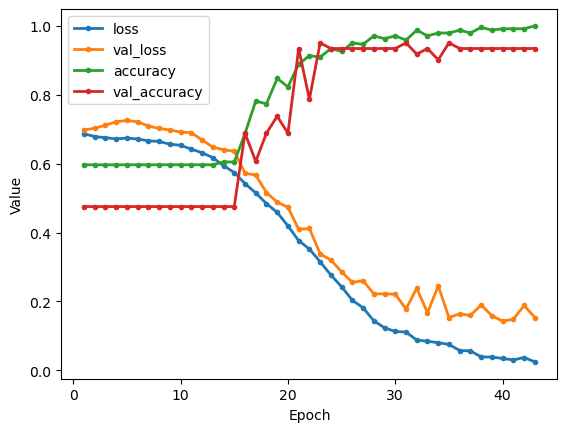

In [33]:
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=6</li></ul>
</h4>

In [34]:
k = 6
sequences   = dataset['sequence']
kmers_count = []
for i in range(len(sequences)):
    kmers_count.append(kmer_count(sequences[i], k=k, step=1))

In [35]:
v = DictVectorizer(sparse=False)
feature_values = v.fit_transform(kmers_count)
feature_names = v.get_feature_names_out()
X_6 = pd.DataFrame(feature_values, columns=feature_names)
X_6.head()

,AAAAAA,AAAAAC,AAAAAG,AAAAAT,AAAACA,AAAACC,AAAACG,AAAACT,AAAAGA,AAAAGC,...,TTTTCG,TTTTCT,TTTTGA,TTTTGC,TTTTGG,TTTTGT,TTTTTA,TTTTTC,TTTTTG,TTTTTT
0,0.002182,0.000000,0.000436,0.000436,0.000436,0.000436,0.000000,0.000000,0.000436,0.000873,...,0.000436,0.001745,0.000873,0.000873,0.002182,0.001309,0.001309,0.000873,0.001745,0.001745
1,0.005450,0.000000,0.000681,0.002725,0.000681,0.000000,0.000000,0.000681,0.000681,0.000000,...,0.000000,0.004087,0.000000,0.001362,0.000681,0.001362,0.002044,0.001362,0.002044,0.004768
2,0.000339,0.000339,0.000339,0.001016,0.000677,0.000000,0.000339,0.000339,0.001355,0.000339,...,0.000339,0.002370,0.001693,0.000339,0.000339,0.002370,0.001355,0.001016,0.002032,0.002032
3,0.005000,0.001364,0.001818,0.000455,0.000455,0.000455,0.000000,0.000455,0.001818,0.000455,...,0.000455,0.002727,0.000000,0.000909,0.000455,0.000909,0.002727,0.001818,0.000455,0.004091
4,0.001004,0.001505,0.001505,0.000502,0.002007,0.000000,0.000502,0.000502,0.000000,0.001004,...,0.000000,0.002509,0.000502,0.000000,0.001505,0.002007,0.003512,0.001004,0.000502,0.006021


In [36]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_6, y, train_size=0.8, stratify=y)

NUM_CLASS  = 1
SEQ_LENGTH = 4**k

* <span style="color: blue; font-weight: bold;">MODEL 4 : FEED-FORWARD NETWORKS</span>

In [37]:
name="FEEDFORWARD_k6"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=20)
save_callback = model_checkpoint(name)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
scores = model.evaluate(X_test, y_test, verbose=0)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

Model: "FEEDFORWARD_k6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,090,049 (4.16 MB)

 Trainable params: 1,090,049 (4.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5640 - loss: 0.6926 - val_accuracy: 0.6066 - val_loss: 0.6886
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5990 - loss: 0.6888 - val_accuracy: 0.6066 - val_loss: 0.6842
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5812 - loss: 0.6859 - val_accuracy: 0.6066 - val_loss: 0.6796
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5776 - loss: 0.6831 - val_accuracy: 0.6066 - val_loss: 0.6752
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5385 - loss: 0.6886 - val_accuracy: 0.6066 - val_loss: 0.6724
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5703 - loss: 0.6786 - val_accuracy: 0.6066 - val_loss: 0.6687
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5844 - loss: 0.6733 - val_accuracy: 0.6066 - val_loss: 0.6648
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5448 - loss: 0.6817 - val_accuracy: 0.6066 - val_loss:

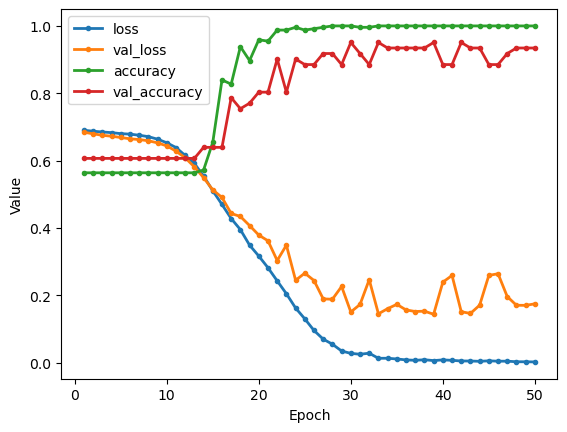

In [38]:
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

<div style="background-color: #80c4e6; padding: 0.5em;">
    <b>RECAP</b>: BEST MODEL FOUND
    
    * k = 6, acc: 96.05%
    
</div>